In [1]:
import sys
sys.path.insert(0,"/mnt/c/gitreps/SlowQuant/")
import numpy as np
import time
import matplotlib.pyplot as plt
from slowquant import shortcuts as SQ

In [2]:
settings = {'basisset':'3-21G'}
molecule = np.array([[4,0,0,0],
                [4,0.0,0.0,0.0]])
pathtobasis = '/mnt/c/gitreps/SlowQuant/slowquant/basissets/'

In [3]:
def doublebar(i,j,k,l, Vee):
    return Vee[i,j,k,l] - Vee[i,j,l,k]

# Dynamics polarizability:
# Introduction to the calculation of molecular properties by response theory
# by Julien Toulouse

# Dosen't seem to have the right behavior, find the bug!
# Transform of 1 electron integrals is not tested properly!
def polarizability(F, C, VeeMO, occ, omega, mux, muy, muz):
    # midx used to slice arrays and for ar,bs combined
    # arrayed indecies
    midx = occ*(len(F)-occ)
    
    CT = np.transpose(C)
    eps = np.dot(np.dot(CT, F),C)
    
    # Construct mu's
    mutot = np.zeros((3,midx)) 
    aridx = -1
    for a in range(0, occ):
        for r in range(occ, len(F)):
            aridx += 1
            # Seem like there is no difference in switching r and a
            # this seem unexpected?
            mutot[0,aridx] = mux[r,a]
            mutot[1,aridx] = muy[r,a]
            mutot[2,aridx] = muz[r,a]
            
    # Construct A and B
    A = np.zeros((midx, midx))
    B = np.zeros((midx, midx))
    aridx = -1
    for a in range(0, occ):
        for r in range(occ, len(F)):
            aridx += 1
            bsidx = -1
            for b in range(0, occ):
                for s in range(occ, len(F)):
                    bsidx += 1
                    #A[aridx,bsidx] = VeeMO[r,b,a,s] - VeeMO[r,b,s,a]
                    #B[aridx,bsidx] = VeeMO[r,s,a,b] - VeeMO[r,s,b,a]
                    A[aridx,bsidx] = doublebar(r,b,a,s, VeeMO)
                    B[aridx,bsidx] = doublebar(r,s,a,b, VeeMO)
                    if a == b and r == s:
                        A[aridx,bsidx] += eps[r,r] - eps[a,a]
    
    # Construct AB matrix and ONE matrix
    ABmat = np.zeros((2*midx,2*midx))
    ONEmat = np.zeros((2*midx,2*midx)) 
    ABmat[0:midx, 0:midx] = A
    ABmat[0:midx, midx:2*midx] = B
    # A^T and A^T == A and B ?? 
    ABmat[midx:2*midx, 0:midx] = np.transpose(B)
    ABmat[midx:2*midx, midx:2*midx] = np.transpose(A)
    
    #ONEmat[0:midx, 0:midx] = 1
    #ONEmat[0:midx, midx:2*midx] = 0
    #ONEmat[midx:2*midx, 0:midx] = 0
    #ONEmat[midx:2*midx, midx:2*midx] = -1
    for i in range(0, len(ONEmat)):
        if i<midx:
            ONEmat[i,i] = 1
        else:
            ONEmat[i,i] = -1

    # Calc polarizability
    alphaij = np.zeros((3,3))
    ABONEinv = np.linalg.inv(ABmat-omega*ONEmat)
    for i in range(0, 3):
        mu_i = np.zeros(2*midx)
        mu_i[0:midx] = mutot[i,:]
        # mu_i* == mu_i ?? No difference, when only real numbers?
        mu_i[midx:] = mutot[i,:]
        for j in range(0, 3):
            mu_j = np.zeros(2*midx)
            mu_j[0:midx] = mutot[j,:]
            mu_j[midx:] = mutot[j,:]
            
            # For real numbers mu_i^dagger = mu_i^T ??
            alphaij[i,j] = np.dot(np.transpose(mu_i), np.dot(ABONEinv, mu_j))

    return alphaij

In [4]:
VNN, VNe, S, Te, Vee = SQ.Integrals(molecule, settings, pathtobasis)
EHF, C, F, D, iterations = SQ.HartreeFock(molecule, VNN, Te, S, VNe, Vee)
mu_x, mu_y, mu_z = SQ.dipoleintegral(molecule, settings, pathtobasis)
VeeMO = SQ.Transform2eMO(Vee, C)
mu_xMO = SQ.Transform1eMO(mu_x, C)
mu_yMO = SQ.Transform1eMO(mu_y, C)
mu_zMO = SQ.Transform1eMO(mu_z, C)
occ = int(molecule[0,0])

VeeMOspin = SQ.Transform2eSPIN(VeeMO)
mu_xMOspin = SQ.Transform1eSPIN(mu_xMO)
mu_yMOspin = SQ.Transform1eSPIN(mu_yMO)
mu_zMOspin = SQ.Transform1eSPIN(mu_zMO)
Fspin = SQ.Transform1eSPIN(F)
Cspin = SQ.Transform1eSPIN(C)

In [5]:
calc = np.zeros((2,100))
for i in range(0, 100):
    omega = i*0.3/100
    alphaij = polarizability(Fspin, Cspin, VeeMOspin, occ, omega, mu_xMOspin, mu_yMOspin, mu_zMOspin)
    calc[0,i] = omega
    calc[1,i] = alphaij[0,0]

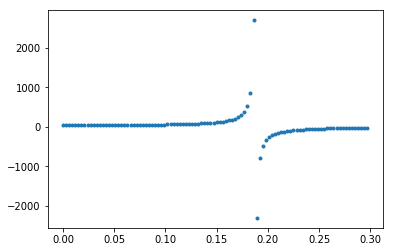

In [6]:
import matplotlib.pyplot as plt
plt.plot(calc[0,:],calc[1,:],'.')
plt.show()

In [13]:
F=Fspin
C=Cspin
VeeMO=VeeMOspin
omega=0.0
mux=mu_xMOspin
muy=mu_yMOspin
muz=mu_zMOspin

# midx used to slice arrays and for ar,bs combined
# arrayed indecies
midx = occ*(len(F)-occ)

CT = np.transpose(C)
eps = np.dot(np.dot(CT, F),C)

# Construct mu's
mutot = np.zeros((3,midx)) 
aridx = -1
for a in range(0, occ):
    for r in range(occ, len(F)):
        aridx += 1
        mutot[0,aridx] = mux[r,a]
        mutot[1,aridx] = muy[r,a]
        mutot[2,aridx] = muz[r,a]

# Construct A and B
A = np.zeros((midx, midx))
B = np.zeros((midx, midx))
aridx = -1
for a in range(0, occ):
    for r in range(occ, len(F)):
        aridx += 1
        bsidx = -1
        for b in range(0, occ):
            for s in range(occ, len(F)):
                bsidx += 1
                #A[aridx,bsidx] = VeeMO[r,b,a,s] - VeeMO[r,b,s,a]
                #B[aridx,bsidx] = VeeMO[r,s,a,b] - VeeMO[r,s,b,a]
                A[aridx,bsidx] = doublebar(r,b,a,s, VeeMO)
                B[aridx,bsidx] = doublebar(r,s,a,b, VeeMO)
                if a == b and r == s:
                    A[aridx,bsidx] += eps[r,r] - eps[a,a]

# Construct AB matrix and ONE matrix
ABmat = np.zeros((2*midx,2*midx))
ONEmat = np.zeros((2*midx,2*midx)) 
ABmat[0:midx, 0:midx] = A
ABmat[0:midx, midx:2*midx] = B
ABmat[midx:2*midx, 0:midx] = B
ABmat[midx:2*midx, midx:2*midx] = A

#ONEmat[0:midx, 0:midx] = 1
#ONEmat[0:midx, midx:2*midx] = 0
#ONEmat[midx:2*midx, 0:midx] = 0
#ONEmat[midx:2*midx, midx:2*midx] = -1
for i in range(0, len(ONEmat)):
    if i<midx:
        ONEmat[i,i] = 1
    else:
        ONEmat[i,i] = -1
            
# Calc polarizability
alphaij = np.zeros((3,3))
ABONEinv = np.linalg.inv(ABmat-omega*ONEmat)
for i in range(0, 3):
    mu_i = np.zeros(2*midx)
    mu_i[0:midx] = mutot[i,:]
    mu_i[midx:] = mutot[i,:]
    for j in range(0, 3):
        mu_j = np.zeros(2*midx)
        mu_j[0:midx] = mutot[j,:]
        mu_j[midx:] = mutot[j,:]

        alphaij[i,j] = np.dot(np.dot(np.transpose(mu_i), ABONEinv), mu_j)

In [14]:
alphaij

array([[  4.10821305e+01,   5.32907052e-14,  -1.31561428e-14],
       [  8.88178420e-15,   4.10821305e+01,  -1.16573418e-15],
       [ -5.77315973e-15,  -2.72004641e-15,   4.10821305e+01]])